In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 95x95 matrix of increased log odds of co-morbidity of condition i given condition j
vmat = pd.read_csv('comorbidity_odds_matrix.csv', index_col=0)
# 95x95 matrix of p-value from logistic regression
pmat = pd.read_csv('comorbidity_pmat_matrix.csv', index_col=0)

In [4]:
print('min = %.2f' % vmat.min().min())
print('max = %.2f' % vmat.max().max())
print('nonzero = %d' % (vmat != 0).sum().sum())
print('95x94 =', 95*94)

min = -12.36
max = 6.03
nonzero = 8930
95x94 = 8930


In [5]:
# remove values that are not statisticaly significative (p > 0.05)
print('removing %d values' % (pmat >= 0.05).sum().sum())
mask = pmat < 0.05
vmat = vmat[mask].fillna(0)

removing 2236 values


In [6]:
# remove negative values
print('removing %d values' % (vmat < 0).sum().sum())
vmat = vmat[vmat > 0].fillna(0)
# rationale:
# the scale is logarithmic: negative values correspond to odds increase between 0 and 1
# odds increase in between 0 and 1 means that having condition j decreases the odds of having condition i

removing 2915 values


In [7]:
print('min = %.2f' % vmat.min().min())
print('max = %.2f' % vmat.max().max())
print('nonzero = %d' % (vmat != 0).sum().sum())

min = 0.00
max = 6.03
nonzero = 3779


In [8]:
vmat

,AHRQ_AbdominalHernia_DT,AHRQ_AcquiredDeformities_DT,AHRQ_AdjustmentDO_DT,AHRQ_Anemia_DT,AHRQ_Asthma_DT,AHRQ_AttentionDeficitDO_DT,AHRQ_BacterialInfection_DT,AHRQ_BiliaryTractDs_DT,AHRQ_Burns_DT,AHRQ_CNSInfection_DT,...,NEPEC_MDD_DT,NEPEC_AFBPDX_DT,NEPEC_PTSD_DT,NEPEC_DXODep_DT,NEPEC_ANXunsp_DT,NEPEC_ANXgen_DT,dmdxDT,cancerdxDT,anomdxDT,genitaldxDT
AHRQ_AbdominalHernia_DT,0.000000,0.000000,0.000000,0.090966,0.252191,0.000000,0.000000,0.710723,0.000000,0.000000,...,0.000000,0.193681,0.218394,0.566455,0.000000,0.0,0.000000,0.098747,0.000000,0.170254
AHRQ_AcquiredDeformities_DT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.465003,0.000000,...,0.000000,0.000000,0.234353,0.495289,0.000000,0.0,0.000000,0.000000,0.870268,0.000000
AHRQ_AdjustmentDO_DT,0.070200,0.138657,0.000000,0.000000,0.100560,0.000000,0.000000,0.000000,0.359342,0.000000,...,0.000000,0.000000,0.000000,1.008589,0.173898,0.0,0.000000,0.000000,0.000000,0.120009
AHRQ_Anemia_DT,0.168454,0.000000,0.000000,0.000000,0.000000,0.000000,0.603858,0.341700,0.314066,0.754466,...,0.000000,0.179997,0.000000,0.519196,0.000000,0.0,0.102596,0.148492,0.000000,0.164761
AHRQ_Asthma_DT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.281069,0.000000,...,0.000000,0.246626,0.305148,0.590638,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NEPEC_ANXgen_DT,0.123031,0.080503,0.206096,0.000000,0.131367,0.239518,0.000000,0.000000,0.000000,0.000000,...,0.391847,0.000000,0.156169,0.944590,1.080603,0.0,0.000000,0.000000,0.000000,0.110762
dmdxDT,0.000000,0.000000,0.000000,0.000000,0.163565,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.259720,0.205407,0.539875,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
cancerdxDT,0.445680,0.000000,0.000000,0.202946,0.000000,0.000000,0.000000,0.163758,0.000000,0.000000,...,0.000000,0.000000,0.138285,0.473643,0.000000,0.0,0.000000,0.000000,0.000000,0.478656
anomdxDT,0.140942,1.543945,0.040799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.189222,0.483185,0.000000,0.0,0.000000,0.000000,0.000000,0.187030


In [9]:
from collections import namedtuple,defaultdict
import seaborn as sns
import networkx as nx

In [34]:
G = nx.from_pandas_adjacency(vmat, create_using=nx.DiGraph)
print(G)
print()
print('directed =', nx.is_directed(G))
print('weighted =', nx.is_weighted(G))
print('nodes =', nx.number_of_nodes(G))
print('edges =', nx.number_of_edges(G))
print()
print('selfloops =', nx.number_of_selfloops(G))
print('WCCs =', nx.number_weakly_connected_components(G))
print('SCCs =', nx.number_strongly_connected_components(G))
print('density = %.2f' % nx.density(G))
print('3779/(95x95) = %.2f' % (3779/(95*95)))
out_degrees = [G.out_degree(n) for n in G.nodes]
print()
print('average out degree = %.2f' % np.mean(out_degrees))
print('min out degree =', np.min(out_degrees))
print('max out degree =', np.max(out_degrees))
print()
out_strengths = [G.out_degree(n, weight = 'weight') for n in G.nodes]
print('average out strength = %.2f' % np.mean(out_strengths))
print('min out strength = %.2f' % np.min(out_strengths))
print('max out strength = %.2f' % np.max(out_strengths))
in_degrees = [G.in_degree(n) for n in G.nodes]
print()
print('average in degree = %.2f' % np.mean(in_degrees))
print('min in degree =', np.min(in_degrees))
print('max in degree =', np.max(in_degrees))
print()
in_strengths = [G.in_degree(n, weight = 'weight') for n in G.nodes]
print('average in strength = %.2f' % np.mean(in_strengths))
print('min in strength = %.2f' % np.min(in_strengths))
print('max in strength = %.2f' % np.max(in_strengths))
print()
min_weight = float('inf')
for u, v, data in G.edges(data=True): min_weight = min(min_weight, data['weight'])
print('min weight = %.2f' % min_weight)
max_weight = float('-inf')
for u, v, data in G.edges(data=True): max_weight = max(max_weight, data['weight'])
print('max weight = %.2f' % max_weight)

DiGraph with 95 nodes and 3779 edges

directed = True
weighted = True
nodes = 95
edges = 3779

selfloops = 0
WCCs = 1
SCCs = 1
density = 0.42
3779/(95x95) = 0.42

average out degree = 39.78
min out degree = 19
max out degree = 66

average out strength = 16.60
min out strength = 6.26
max out strength = 38.37

average in degree = 39.78
min in degree = 2
max in degree = 94

average in strength = 16.60
min in strength = 0.82
max in strength = 61.85

min weight = 0.02
max weight = 6.03


In [11]:
print('node? AbdominalHernia')
print(G.has_node('AHRQ_AbdominalHernia_DT'))
print()
print('edge? AbdominalHernia -> AcquiredDeformities')
print(G.has_edge('AHRQ_AbdominalHernia_DT', 'AHRQ_AcquiredDeformities_DT'))
print()
print('edge? AbdominalHernia -> Anemia')
print(G.has_edge('AHRQ_AbdominalHernia_DT', 'AHRQ_Anemia_DT'))
print(G.edges[('AHRQ_AbdominalHernia_DT', 'AHRQ_Anemia_DT')])
print()
print('out_degree(AbdominalHernia) =', G.out_degree('AHRQ_AbdominalHernia_DT'))
print('out_strength(AbdominalHernia) = %.2f' % G.out_degree('AHRQ_AbdominalHernia_DT', weight='weight'))

node? AbdominalHernia
True

edge? AbdominalHernia -> AcquiredDeformities
False

edge? AbdominalHernia -> Anemia
True
{'weight': 0.0909660098139276}

out_degree(AbdominalHernia) = 39
out_strength(AbdominalHernia) = 10.52


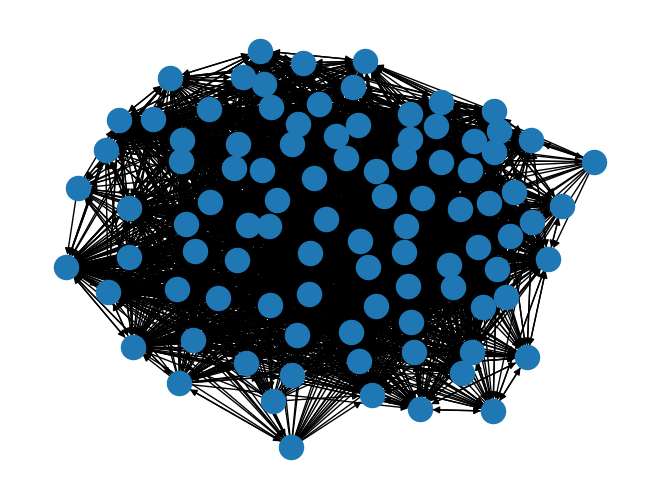

In [12]:
pos = nx.spring_layout(G)
nx.draw(G, pos, arrows=True)

In [13]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8.5, 4))
#fig.suptitle('Complementary cumulative distribution')
#ax1.set_title('Degree')
#sns.ecdfplot(degrees, complementary = True, log_scale = (True, True), ax=ax1)
#ax2.set_title('Strength')
#sns.ecdfplot(strengths, complementary = True, log_scale = (True, True), ax=ax2)
#plt.show()

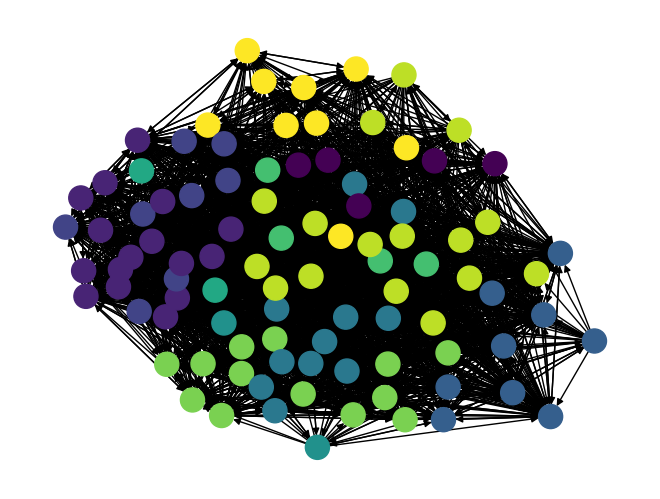

In [22]:
#Find the best partition of a graph using the Louvain Community Detection Algorithm.
louvain_communities = nx.community.louvain_communities(G, weight='weight', seed=123)
# Organize nodes by community
color_map = []
for node in G.nodes():
    for i, community in enumerate(louvain_communities):
        if node in community:
            color_map.append(i)

# Visualize
pos = nx.spring_layout(G)  # Adjust layout if needed
nx.draw(G, pos, node_color=color_map, with_labels=False)
plt.show()

In [23]:
#how many communities?
print(len(louvain_communities))

11


In [24]:
#which are the diseases in each community?
for i, community in enumerate(louvain_communities):
    print(f'Community {i+1}: {community}')
    print(f'number of nodes {len(community)}')
    print()

Community 1: {'AHRQ_OthLowerRespiratoryDs_DT', 'AHRQ_COPDAndBronchiectasis_DT', 'AHRQ_Asthma_DT', 'AHRQ_RespiratoryInfections_DT', 'AHRQ_OthUpperRespiratoryDs_DT'}
number of nodes 5

Community 2: {'AHRQ_SystemicLupus_DT', 'AHRQ_DisOfWhiteBloodCells_DT', 'AHRQ_LiverDs_DT', 'AHRQ_RespiratoryFailure_DT', 'AHRQ_Pleurisy_DT', 'AHRQ_DisOfTheHeart_DT', 'AHRQ_DisOfArteries_DT', 'AHRQ_OthHematologicConditions_DT', 'AHRQ_DisOfTheUrinarySystem_DT', 'AHRQ_IntestinalInfection_DT', 'AHRQ_Anemia_DT', 'AHRQ_CoagulationDO_DT', 'AHRQ_PancreaticDO_DT', 'AHRQ_BiliaryTractDs_DT', 'AHRQ_FluidAndElectrolyteDO_DT', 'AHRQ_BacterialInfection_DT'}
number of nodes 16

Community 3: {'AHRQ_LowerGIDO_DT', 'AHRQ_GIHemorrhage_DT', 'AHRQ_UpperGIDO_DT', 'AHRQ_NoninfectiousGastroenterit0', 'AHRQ_DisOfVeins_DT', 'cancerdxDT', 'AHRQ_AbdominalHernia_DT', 'AHRQ_OthGIDO_DT'}
number of nodes 8

Community 4: {'AHRQ_OthConnectiveTissueDs_DT', 'AHRQ_Spondylosis_DT', 'AHRQ_NontraumaticJointDO_DT', 'anomdxDT', 'AHRQ_OthBoneDs_DT', 

In [25]:
#values of communities modularity
modularity = nx.community.quality.modularity(G, louvain_communities, weight='weight')
print(f'Louvain Modularity: {modularity}')
partition = nx.community.quality.partition_quality(G, louvain_communities)
print(f'Partition: {partition}')


Louvain Modularity: 0.24196409517623563
Partition: (0.21354855781952897, 0.647592385218365)


In [26]:
greedy_communities=nx.community.greedy_modularity_communities(G, weight='weight', cutoff=5, best_n=15, resolution=1.3)
#which are the diseases in each community?
for i, community in enumerate(greedy_communities):
    print(f'Community {i+1}: {community}')
    print(f'number of nodes {len(community)}')
    print()

Community 1: frozenset({'AHRQ_LowerGIDO_DT', 'AHRQ_DisOfWhiteBloodCells_DT', 'AHRQ_LiverDs_DT', 'AHRQ_NoninfectiousGastroenterit0', 'AHRQ_DisOfVeins_DT', 'AHRQ_Pleurisy_DT', 'cancerdxDT', 'AHRQ_DisOfTheHeart_DT', 'AHRQ_AbdominalHernia_DT', 'AHRQ_OthGIDO_DT', 'AHRQ_OthHematologicConditions_DT', 'AHRQ_GIHemorrhage_DT', 'AHRQ_IntestinalInfection_DT', 'AHRQ_UpperGIDO_DT', 'AHRQ_Anemia_DT', 'AHRQ_CoagulationDO_DT', 'AHRQ_PancreaticDO_DT', 'AHRQ_BiliaryTractDs_DT', 'AHRQ_FluidAndElectrolyteDO_DT'})
number of nodes 19

Community 2: frozenset({'AHRQ_SystemicLupus_DT', 'AHRQ_OthSkinDO_DT', 'AHRQ_OthInflamCondOfSkin_DT', 'AHRQ_Asthma_DT', 'AHRQ_OthUpperRespiratoryDs_DT', 'AHRQ_DisOfMouth_DT', 'AHRQ_OthInfections_DT', 'AHRQ_SkinInfections_DT', 'AHRQ_ImmunityDO_DT', 'AHRQ_COPDAndBronchiectasis_DT', 'AHRQ_DOOfTeethAndJaw_DT', 'AHRQ_OthLowerRespiratoryDs_DT', 'AHRQ_RespiratoryInfections_DT', 'AHRQ_EyeDO_DT', 'AHRQ_ViralInfection_DT', 'AHRQ_Mycoses_DT'})
number of nodes 16

Community 3: frozenset({'A

In [27]:
#values of communities modularity
modularity = nx.community.quality.modularity(G, greedy_communities, weight='weight')
print(f'Modularity: {modularity}')
partition = nx.community.quality.partition_quality(G, greedy_communities)
print(f'Partition: {partition}')

Modularity: 0.25859506441527275
Partition: (0.2651495104525007, 0.6529675251959687)


{'Community_1': 'In: 77.11579358885521\nOut: 59.021554845191325', 'Community_2': 'In: 251.04101605940173\nOut: 378.22366840686965', 'Community_3': 'In: 122.43047782542537\nOut: 113.18799705348435', 'Community_4': 'In: 114.4957290802814\nOut: 98.54425258278816', 'Community_5': 'In: 250.12475662374277\nOut: 211.69793320125223', 'Community_6': 'In: 18.069038966525223\nOut: 43.518250087665464', 'Community_7': 'In: 28.329721140907562\nOut: 35.209314927122456', 'Community_8': 'In: 55.9471699324151\nOut: 49.33438997948593', 'Community_9': 'In: 338.92118715486043\nOut: 296.3943935806888', 'Community_10': 'In: 263.9869324431332\nOut: 211.15054763908628', 'Community_11': 'In: 56.67388490833579\nOut: 80.85340542024923'}


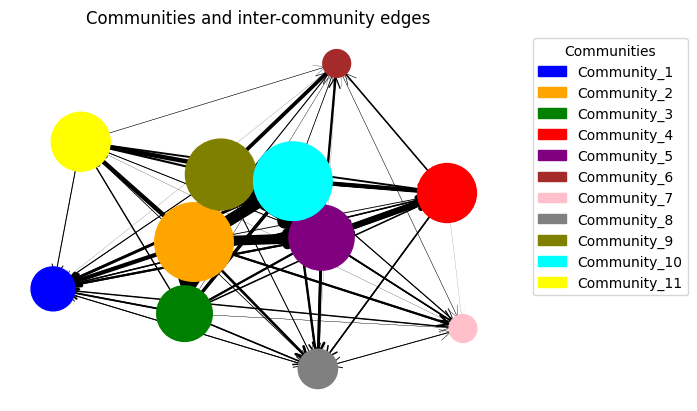

<Figure size 200000x180000 with 0 Axes>

In [38]:
import matplotlib.patches as mpatches
# ------------------------
# 2. Create 'Supernodes' and Calculate Strengths
# ------------------------

# Create a new graph for the supernodes
G_super = nx.DiGraph()

# Calculate strengths and add supernodes
for community_id, nodes in enumerate(louvain_communities):
    community_size = len(nodes)

    # In-strength: Sum of incoming weights to the community
    in_strength = sum(G.in_degree(node, weight='weight') for node in nodes)

    # Out-strength: Sum of outgoing weights from the community
    out_strength = sum(G.out_degree(node, weight='weight') for node in nodes)

    # Create a supernode representing the community
    G_super.add_node(f'Community_{community_id + 1}', size=community_size, 
                     in_strength=in_strength, out_strength=out_strength)

# ------------------------
# 3. Calculate Edge Weights for Supernodes 
# ------------------------

for u, v, data in G.edges(data=True):
    u_comm = next(i for i, comm in enumerate(louvain_communities) if u in comm)
    v_comm = next(i for i, comm in enumerate(louvain_communities) if v in comm)

    if u_comm != v_comm:  # Only consider edges between communities
        weight = data['weight']
        super_u = f'Community_{u_comm + 1}'
        super_v = f'Community_{v_comm + 1}'

        # Modification: Track inflows and outflows
        if G_super.has_edge(super_u, super_v):
            G_super[super_u][super_v]['weight'] += weight
            #G_super[super_u][super_v]['outflow'] += weight  # Outflow from super_u
            #G_super[super_v][super_u]['inflow'] += weight  # Inflow to super_v
        else:
            #G_super.add_edge(super_u, super_v, outflow=weight, inflow=0)
            G_super.add_edge(super_u, super_v, weight=weight)
   
# ------------------------
# 4. Visualization
# ------------------------
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'yellow'] 
color_map = dict(zip([f'Community_{i + 1}' for i in range(len(louvain_communities))], colors))


# Get positions for drawing (you might want a more sophisticated layout)
pos = nx.spring_layout(G_super)

# Draw communities with size based on their member count
node_sizes = [data['size'] * 200 for _, data in G_super.nodes(data=True)]
# Draw communities with assigned colors
node_colors = [color_map[node] for node in G_super.nodes()]
nx.draw_networkx_nodes(G_super, pos, node_size=node_sizes, node_color=node_colors)


# Draw edges with width based on aggregated weight
edge_widths = [data['weight'] * 0.2 for _, _, data in G_super.edges(data=True)]
nx.draw_networkx_edges(G_super, pos, width=edge_widths,arrowstyle='->', arrowsize=20)
# Edges with Directionality
#max_flow = max(max(d['inflow'], d['outflow']) for _, _, d in G_super.edges(data=True))
#for (u, v, data) in G_super.edges(data=True):
#    width = max(data['inflow'], data['outflow']) * 3 / max_flow  # Scale width by flow
#    nx.draw_networkx_edges(G_super, pos, edgelist=[(u, v)], width=width, 
#                           arrowstyle='->', arrowsize=15)

# Add labels with in-strength and out-strength 
labels = {node: f"In: {data['in_strength']}\nOut: {data['out_strength']}"
          for node, data in G_super.nodes(data=True)}         
#nx.draw_networkx_labels(G_super, pos,  labels)
print(labels)

# Add a legend
patches = [mpatches.Patch(color=color, label=community) for community, color in color_map.items()]
plt.legend(handles=patches, title='Communities',bbox_to_anchor=(1.04, 1), loc="upper left")
plt.axis('off')
plt.title('Communities and inter-community edges')
plt.figure(figsize=(2000,1800))
plt.show()


In [29]:
print(f"min in-strenght: {min(G_super.nodes(data=True), key=lambda x: x[1]['in_strength'])}")
print(f"max in-strenght: {max(G_super.nodes(data=True), key=lambda x: x[1]['in_strength'])}")
print(f"min out-strenght: {min(G_super.nodes(data=True), key=lambda x: x[1]['out_strength'])}")
print(f"max out-strenght: {max(G_super.nodes(data=True), key=lambda x: x[1]['out_strength'])}")

min in-strenght: ('Community_6', {'size': 2, 'in_strength': 18.069038966525223, 'out_strength': 43.518250087665464})
max in-strenght: ('Community_9', {'size': 13, 'in_strength': 338.92118715486043, 'out_strength': 296.3943935806888})
min out-strenght: ('Community_7', {'size': 2, 'in_strength': 28.329721140907562, 'out_strength': 35.209314927122456})
max out-strenght: ('Community_2', {'size': 16, 'in_strength': 251.04101605940173, 'out_strength': 378.22366840686965})


In [30]:
print(f"min edge weight: {min(G_super.edges(data=True), key=lambda x: x[2]['weight'])}")
print(f"max edge weight: {max(G_super.edges(data=True), key=lambda x: x[2]['weight'])}")

min edge weight: ('Community_4', 'Community_7', {'weight': 0.112645216471077})
max edge weight: ('Community_2', 'Community_9', {'weight': 55.57963715317364})


In [31]:
print(G_super.edges(data=True))

[('Community_1', 'Community_5', {'weight': 7.182602016347371}), ('Community_1', 'Community_9', {'weight': 3.638993019268768}), ('Community_1', 'Community_2', {'weight': 5.0938320637924175}), ('Community_1', 'Community_4', {'weight': 5.1834653335864616}), ('Community_1', 'Community_3', {'weight': 5.091650328314448}), ('Community_1', 'Community_11', {'weight': 1.2461833732554586}), ('Community_1', 'Community_8', {'weight': 3.2491729694525278}), ('Community_1', 'Community_7', {'weight': 1.669117357281511}), ('Community_1', 'Community_10', {'weight': 8.831422403376582}), ('Community_2', 'Community_3', {'weight': 39.37064035918778}), ('Community_2', 'Community_5', {'weight': 35.757014371033975}), ('Community_2', 'Community_9', {'weight': 55.57963715317364}), ('Community_2', 'Community_1', {'weight': 15.177982036232367}), ('Community_2', 'Community_11', {'weight': 16.07161257622741}), ('Community_2', 'Community_8', {'weight': 9.528188065258952}), ('Community_2', 'Community_7', {'weight': 7.8